# Who is the real winner

Importing Libraries and Data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [25]:
data = pd.read_csv('train.csv')
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2059 non-null   int64 
 1   Candidate       2059 non-null   object
 2   Constituency ∇  2059 non-null   object
 3   Party           2059 non-null   object
 4   Criminal Case   2059 non-null   int64 
 5   Total Assets    2059 non-null   object
 6   Liabilities     2059 non-null   object
 7   state           2059 non-null   object
 8   Education       2059 non-null   object
dtypes: int64(2), object(7)
memory usage: 144.9+ KB


In [26]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              1374 non-null   int64 
 1   Candidate       1374 non-null   object
 2   Constituency ∇  1374 non-null   object
 3   Party           1374 non-null   object
 4   Criminal Case   1374 non-null   int64 
 5   Total Assets    1374 non-null   object
 6   Liabilities     1374 non-null   object
 7   state           1374 non-null   object
dtypes: int64(2), object(6)
memory usage: 86.0+ KB


Data Preprocessing

In [27]:
import re

def convert_assets(assets_str):
    # Remove the '+' sign and whitespace
    assets_str = assets_str.replace('+', '').replace(' ', '')
    
    if 'Crore' in assets_str:
        value = float(re.findall(r'\d+', assets_str)[0])
        return value * 10000000
    elif 'Lac' in assets_str:
        value = float(re.findall(r'\d+', assets_str)[0])
        return value * 100000
    elif 'Thou' in assets_str:
        value = float(re.findall(r'\d+', assets_str)[0])
        return value * 1000
    elif 'Hund' in assets_str:
        value = float(re.findall(r'\d+', assets_str)[0])
        return value * 100
    else:
        return float(assets_str)

# df['Total Assets'] = df['Total Assets'].apply(convert_assets)
# df['Liabilities'] = df['Liabilities'].apply(convert_assets)

In [28]:
def preprocess(df):
    df = df.drop(['Candidate', 'ID'], axis=1)
    df['Total Assets'] = df['Total Assets'].apply(convert_assets)
    df['Liabilities'] = df['Liabilities'].apply(convert_assets)
    df['Constituency'] = df['Constituency ∇'].str.extract(r'\((.*?)\)')
    df['Constituency'] = df['Constituency'].apply(lambda x: x if x in ['SC', 'ST'] else 'General')
    df = df.drop(['Constituency ∇'], axis=1)
    df['Net'] = df['Total Assets'] - df['Liabilities']
    df['Log_Assets'] = np.log(df['Total Assets'] + 1) # Adding 1 to avoid log(0)
    df['Log_Liability'] = np.log(df['Liabilities'] + 1)
    return df

In [29]:
df['Total Assets'] = df['Total Assets'].apply(convert_assets)
df['Liabilities'] = df['Liabilities'].apply(convert_assets)

# Convert 'Education' column to categorical type
df['Education'] = pd.Categorical(df['Education'], ordered=True, categories=['Others', 'Literate', '5th Pass', '8th Pass', '10th Pass', '12th Pass', 'Graduate', 'Graduate Professional' 'Post Graduate', 'Doctorate'])

total_candidates_per_party = df.groupby('Party')['ID'].count()
total_candidates_per_state = df.groupby('state')['ID'].count()

# Filter data based on conditions
more_than_1_case = df[df['Criminal Case'] > 1]
more_than_1_crore_assets = df[df['Total Assets'] > 1e+07]
more_than_12th_pass_education = df[df['Education'] >= '12th Pass']

# Count the number of people in each party for each condition
party_with_more_than_1_case = more_than_1_case.groupby('Party')['ID'].count()
party_with_more_than_1_crore_assets = more_than_1_crore_assets.groupby('Party')['ID'].count()
party_with_more_than_12th_pass_education = more_than_12th_pass_education.groupby('Party')['ID'].count()
State_with_more_than_12th_pass_education = more_than_12th_pass_education.groupby('state')['ID'].count()

normalized_party_with_more_than_1_case = party_with_more_than_1_case / total_candidates_per_party
normalized_party_with_more_than_1_crore_assets = party_with_more_than_1_crore_assets / total_candidates_per_party
normalized_party_with_more_than_12th_pass_education = party_with_more_than_12th_pass_education / total_candidates_per_party
normalized_state_with_more_than_12th_pass_education = State_with_more_than_12th_pass_education / total_candidates_per_state

sc_constituencies = df[df['Constituency ∇'].str.contains('SC')]
st_constituencies = df[df['Constituency ∇'].str.contains('ST')]
other_constituencies = df[~df['Constituency ∇'].str.contains('SC|ST')]

# Count the education levels for each filtered constituency
sc_education_counts = sc_constituencies['Education'].value_counts()
st_education_counts = st_constituencies['Education'].value_counts()
other_education_counts = other_constituencies['Education'].value_counts()


Data Analysis

([<matplotlib.axis.XTick at 0x2023eae0150>,
 [Text(0, 0, '8th Pass'),
  Text(1, 0, '12th Pass'),
  Text(2, 0, 'Graduate'),
  Text(3, 0, '10th Pass'),
  Text(4, 0, 'Others'),
  Text(5, 0, 'Doctorate'),
  Text(6, 0, 'Literate'),
  Text(7, 0, '5th Pass')])

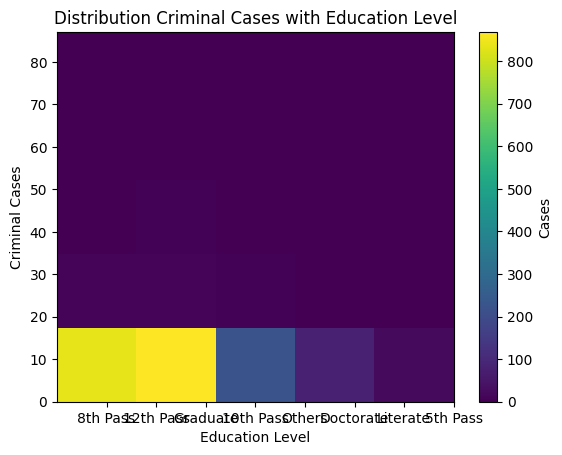

In [30]:
df['Education_'], education_labels = pd.factorize(df['Education'])
# Plotting distribution of criminal cases with education level
plt.hist2d(df['Education_'], df['Criminal Case'], bins=5, cmap='viridis')
plt.colorbar(label='Cases')
plt.xlabel('Education Level')
plt.ylabel('Criminal Cases')
plt.title('Distribution Criminal Cases with Education Level')
plt.xticks(ticks=range(len(education_labels)), labels=education_labels)

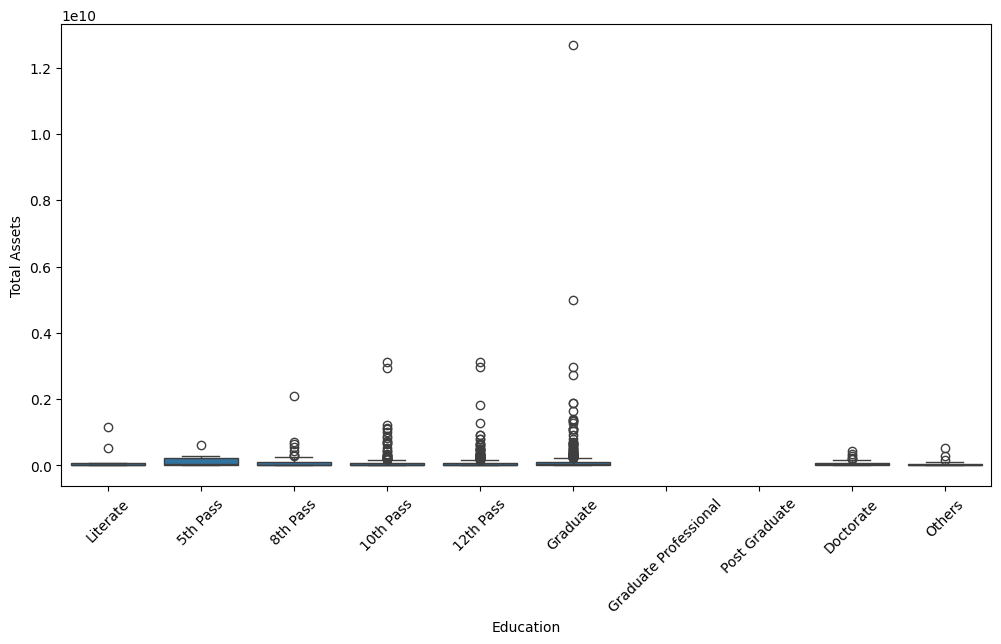

In [31]:
# Box plot of Assets vs Education set education order in graph as 5th 8th 10th 12th Graduate Post Graduate Doctorate Others

plt.figure(figsize=(12, 6))
sns.boxplot(x='Education', y='Total Assets', data=df, order = ['Literate', '5th Pass', '8th Pass', '10th Pass', '12th Pass', 'Graduate', 'Graduate Professional', 'Post Graduate', 'Doctorate', 'Others'])
plt.xticks(rotation=45)
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_22552\61481984.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Total Assets'])


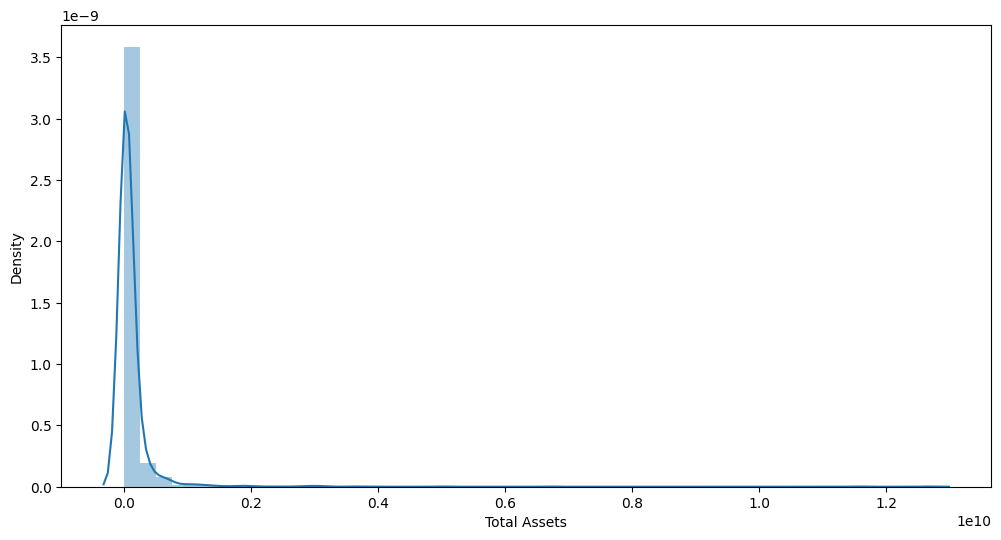

In [32]:
# Plot distribution of Total Assets
plt.figure(figsize=(12, 6))
sns.distplot(df['Total Assets'])
plt.show()

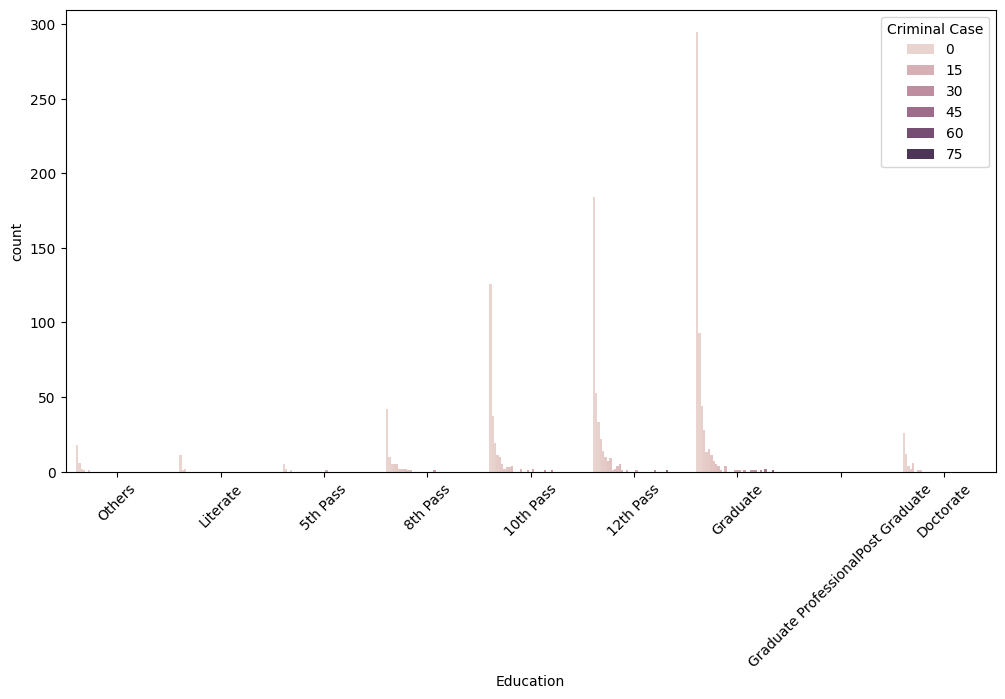

In [34]:
# Plot distribution of criminal cases with education
plt.figure(figsize=(12, 6))
sns.countplot(x='Education', data=df, hue='Criminal Case')
plt.xticks(rotation=45)
plt.show()


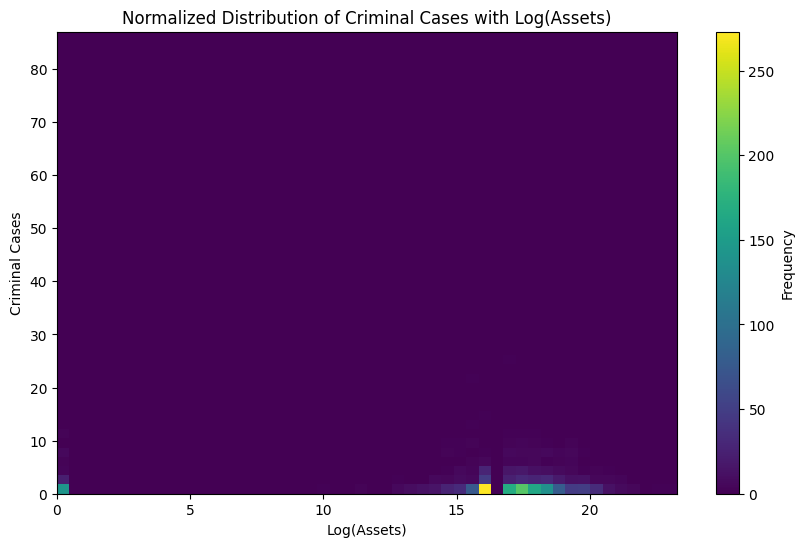

In [35]:
df['Log_Assets'] = np.log(df['Total Assets'] + 1) # Adding 1 to avoid log(0)

# Plot normalized distribution of criminal cases with log-transformed assets
plt.figure(figsize=(10, 6))
plt.hist2d(df['Log_Assets'], df['Criminal Case'], bins=50, cmap='viridis')
plt.colorbar(label='Frequency')
plt.xlabel('Log(Assets)')
plt.ylabel('Criminal Cases')
plt.title('Normalized Distribution of Criminal Cases with Log(Assets)')
plt.show()

Text(0, 0.5, 'Number of People')

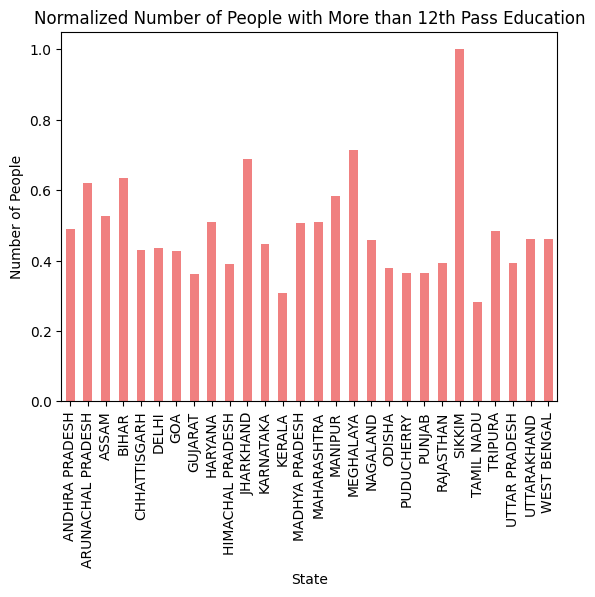

In [36]:
# Plotting number of people with more than 12th Pass education for each State
normalized_state_with_more_than_12th_pass_education.plot(kind='bar', color='lightcoral')
plt.title('Normalized Number of People with More than 12th Pass Education')
plt.xlabel('State')
plt.ylabel('Number of People')

Text(0, 0.5, 'Proportion of People')

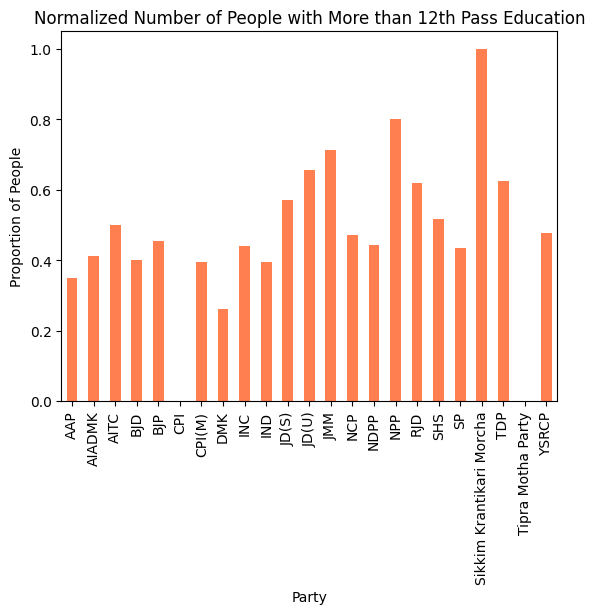

In [37]:
# Plotting number of people with more than 12th Pass education for each party
normalized_party_with_more_than_12th_pass_education.plot(kind='bar', color='coral')
plt.title('Normalized Number of People with More than 12th Pass Education')
plt.xlabel('Party')
plt.ylabel('Proportion of People')

Text(0.5, 1.0, 'Education Level in Other Constituencies')

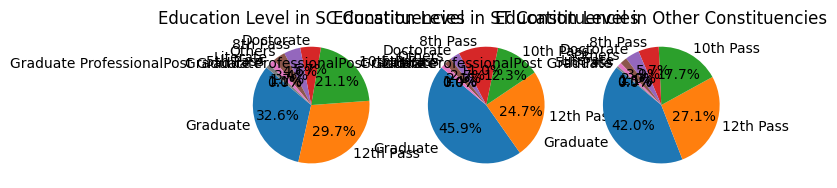

In [38]:
# Pie chart for SC constituencies
plt.subplot(1, 3, 1)
plt.pie(sc_education_counts, labels=sc_education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Education Level in SC Constituencies')

# Pie chart for ST constituencies
plt.subplot(1, 3, 2)
plt.pie(st_education_counts, labels=st_education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Education Level in ST Constituencies')

# Pie chart for other constituencies
plt.subplot(1, 3, 3)
plt.pie(other_education_counts, labels=other_education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Education Level in Other Constituencies')

Finalizing Data and Preprocessing

In [39]:
df = data.copy()
df = preprocess(df)

In [40]:
y = df['Education']
X = df.drop(['Education','Log_Assets','Log_Liability'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Party          2059 non-null   object 
 1   Criminal Case  2059 non-null   int64  
 2   Total Assets   2059 non-null   float64
 3   Liabilities    2059 non-null   float64
 4   state          2059 non-null   object 
 5   Constituency   2059 non-null   object 
 6   Net            2059 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 112.7+ KB


In [41]:
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Criminal Case                   2059 non-null   int64  
 1   Total Assets                    2059 non-null   float64
 2   Liabilities                     2059 non-null   float64
 3   Net                             2059 non-null   float64
 4   Party_AAP                       2059 non-null   bool   
 5   Party_AIADMK                    2059 non-null   bool   
 6   Party_AITC                      2059 non-null   bool   
 7   Party_BJD                       2059 non-null   bool   
 8   Party_BJP                       2059 non-null   bool   
 9   Party_CPI                       2059 non-null   bool   
 10  Party_CPI(M)                    2059 non-null   bool   
 11  Party_DMK                       2059 non-null   bool   
 12  Party_INC                       20

Training and checking accuracy

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.22330097087378642

In [43]:
clf.fit(X, y)

RandomForestClassifier()

Predicting on test dataset

In [46]:
test = preprocess(test)
test = test.drop(['Log_Assets','Log_Liability'], axis=1)
test = pd.get_dummies(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Criminal Case                   1374 non-null   int64  
 1   Total Assets                    1374 non-null   float64
 2   Liabilities                     1374 non-null   float64
 3   Net                             1374 non-null   float64
 4   Party_AAP                       1374 non-null   bool   
 5   Party_AIADMK                    1374 non-null   bool   
 6   Party_AITC                      1374 non-null   bool   
 7   Party_BJD                       1374 non-null   bool   
 8   Party_BJP                       1374 non-null   bool   
 9   Party_CPI                       1374 non-null   bool   
 10  Party_CPI(M)                    1374 non-null   bool   
 11  Party_DMK                       1374 non-null   bool   
 12  Party_INC                       13

In [47]:
prediction = clf.predict(test)
prediction

array(['Graduate', '8th Pass', 'Graduate Professional', ...,
       'Post Graduate', '10th Pass', 'Post Graduate'], dtype=object)

In [48]:
# Save the prediction to a csv file
submission = pd.DataFrame({'ID': range(1, len(prediction) + 1), 'Education': prediction})
submission['ID'] = submission['ID'] - 1
submission.to_csv('new.csv', index=False)